# Mini Project 3

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/MiniProject3/dataset/

/content/gdrive/MyDrive/MiniProject3/dataset


In [ ]:
!pwd

/content/gdrive/MyDrive/MiniProject3/dataset


1.Loading the data:

In [ ]:
datas = pickle.load( open( 'Train.pkl', 'rb' ))
targets = np.genfromtxt('Train_labels.csv', delimiter=',')[1:]

data_test = pickle.load( open('Test.pkl', 'rb' ))

data example

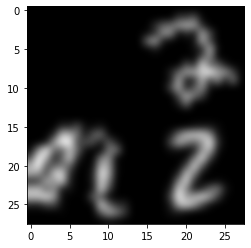

Class 4


In [ ]:
plt.imshow(datas[1234][0], cmap='gray', interpolation="bicubic")
plt.show()
print("Class",int(targets[1234][1]))

Data dimentions

In [ ]:
print("Total number of Samples: ", len(datas))
print("Dimentions of each image: ", datas[1234][0].shape)

Total number of Samples:  60000
Dimentions of each image:  (28, 28)


In [ ]:
print(np.argwhere(np.isnan(datas)))
print(np.argwhere(np.isnan(targets)))

[]
[]


There are no missing values in the training data or targets

Data loaders

In [ ]:
targets=targets.astype(int)
datas = torch.from_numpy(datas[:])
targets = torch.from_numpy(targets[:,1])


random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

dataset = TensorDataset(datas,targets)
print(f"Length of Data : {len(dataset)}")

data_test = torch.from_numpy(data_test[:])


Length of Data : 60000


whole data

In [ ]:
all_data_batch_size=256
all_dataloader = DataLoader(dataset, all_data_batch_size, shuffle = True )

validation

In [ ]:
batch_size_train = 256
batch_size_test = 1000
validatoin_size = 0.1


val_size = int(validatoin_size *len(datas))
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_loader = DataLoader(train_data, batch_size_train, shuffle = True )
test_loader = DataLoader(val_data, batch_size_test)


Length of Train Data : 54000
Length of Validation Data : 6000


In [ ]:
train_accuracy=[]

In [ ]:
def train(epoch, network, data_loader, optimizer, criterion, log_interval, train_losses, train_counter):
  network.train()
  correct = 0
  for batch_idx, (data, target) in enumerate(data_loader):
    data = data.to('cuda')
    target = target.to('cuda')
    optimizer.zero_grad()
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      '''print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))'''
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(data_loader.dataset)))
  print('\nTrain Epoch: {} Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  epoch, loss, correct, len(data_loader.dataset),
  100. * correct / len(data_loader.dataset)))
  acc = ( correct) / len(data_loader.dataset)
  train_accuracy.append(acc.cpu().numpy())


In [ ]:
test_accuracy=[]

In [ ]:
def test(network, test_loader, criterion, test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda')
      target = target.to('cuda')
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  acc = ( correct) / len(test_loader.dataset)
  test_accuracy.append(acc.cpu().numpy())

In [ ]:
def validation(n_epochs, network, train_loader, test_loader, optimizer, criterion, log_interval):
  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
  test(network, test_loader, criterion, test_losses)
  for epoch in range(1, n_epochs + 1):
    train(epoch, network, train_loader, optimizer, criterion, log_interval, train_losses, train_counter)
    test(network, test_loader, criterion, test_losses)
  return train_losses, test_losses


In [ ]:
def prediction(n_epochs, network, alldataloader,data_test, optimizer, criterion, log_interval):
  train_losses = []
  train_counter = []

  for epoch in range(1, n_epochs + 1):
    train(epoch, network, alldataloader, optimizer, criterion, log_interval, train_losses, train_counter)
    print("epoch",epoch+1)
  network.eval()
  with torch.no_grad():
      output = network(data_test.to('cuda'))
      pred = output.data.max(1, keepdim=True)[1]

  np_pred=pred.cpu().numpy().ravel()
  np.savetxt("results.csv", np.transpose(np.stack((np.arange(len(np_pred)),np_pred))), fmt="%s", delimiter=',', header="id,class")
  return train_losses


# Different network structures

# LeNet5

Need to transform images from 28 28 to 32 32

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return F.log_softmax(out)

In [ ]:
transform = transforms.Resize((32,32))
data_test_32 = transform(data_test)
dataset_32 = TensorDataset(transform(datas),targets)
print(f"Length of Data : {len(dataset_32)}")


all_data_batch_size=256

all_dataloader_32 = DataLoader(dataset_32, all_data_batch_size, shuffle = True )
batch_size_train = 256
batch_size_test = 1000
validatoin_size = 0.1


val_size = int(validatoin_size *len(datas))
train_size = len(dataset_32) - val_size

train_data_32,val_data_32 = random_split(dataset_32,[train_size,val_size])
print(f"Length of Train Data : {len(train_data_32)}")
print(f"Length of Validation Data : {len(val_data_32)}")

train_loader_32 = DataLoader(train_data_32, batch_size_train, shuffle = True )
test_loader_32 = DataLoader(val_data_32, batch_size_test)

Length of Data : 60000
Length of Train Data : 54000
Length of Validation Data : 6000


In [ ]:
n_epochs = 100
learning_rate = 0.005
momentum = 0.5
log_interval = 500


In [ ]:
network = LeNet5().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

train_losses, test_losses = validation(n_epochs, network, train_loader_32, test_loader_32, optimizer, criterion, log_interval)

<ipython-input-39-f1afb150b881>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Test set: Avg. loss: 2.3041, Accuracy: 583/6000 (10%)


Train Epoch: 1 Avg. loss: 2.2760, Accuracy: 7241/54000 (13%)


Test set: Avg. loss: 2.2807, Accuracy: 977/6000 (16%)


Train Epoch: 2 Avg. loss: 2.2181, Accuracy: 11991/54000 (22%)


Test set: Avg. loss: 2.2212, Accuracy: 1499/6000 (25%)


Train Epoch: 3 Avg. loss: 2.0716, Accuracy: 15462/54000 (29%)


Test set: Avg. loss: 2.0626, Accuracy: 1770/6000 (30%)


Train Epoch: 4 Avg. loss: 1.8236, Accuracy: 17958/54000 (33%)


Test set: Avg. loss: 1.9017, Accuracy: 2163/6000 (36%)


Train Epoch: 5 Avg. loss: 1.7522, Accuracy: 21057/54000 (39%)


Test set: Avg. loss: 1.7496, Accuracy: 2397/6000 (40%)


Train Epoch: 6 Avg. loss: 1.6424, Accuracy: 24080/54000 (45%)


Test set: Avg. loss: 1.5865, Accuracy: 2711/6000 (45%)


Train Epoch: 7 Avg. loss: 1.3903, Accuracy: 26661/54000 (49%)


Test set: Avg. loss: 1.4451, Accuracy: 3049/6000 (51%)


Train Epoch: 8 Avg. loss: 1.3071, Accuracy: 28753/54000 (53%)


Test set: Avg. loss: 1.3442, Accur

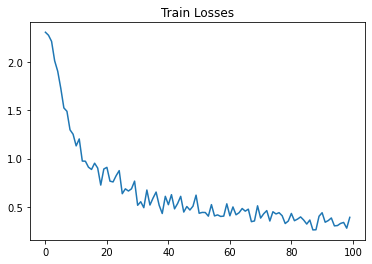

In [ ]:
plt.plot(train_losses)
plt.title("Train Losses")
plt.show()

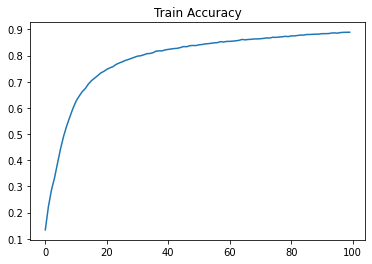

In [ ]:
plt.plot(train_accuracy)
plt.title("Train Accuracy")
plt.show()

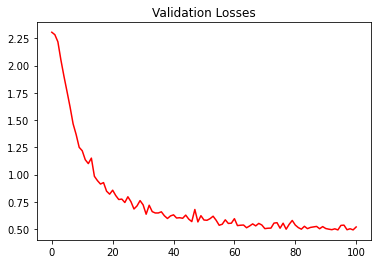

In [ ]:
plt.plot(test_losses,color='red')
plt.title("Validation Losses")
plt.show()

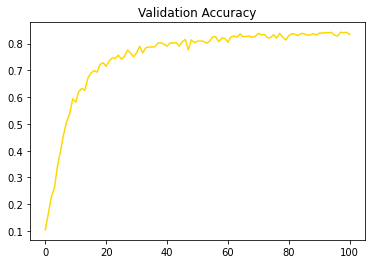

In [ ]:
plt.plot(test_accuracy, color='gold')
plt.title("Validation Accuracy")
plt.show()

epoch 100: 84%

In [ ]:
network = LeNet5().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

prediction(n_epochs, network, all_dataloader_32, data_test_32, optimizer, criterion, log_interval)

<ipython-input-17-f1afb150b881>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307100
epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.275859
epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.092959
epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.963698
epoch 5
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.827205
epoch 6
Train Epoch: 6 [0/60000 (0%)]	Loss: 1.650403
epoch 7
Train Epoch: 7 [0/60000 (0%)]	Loss: 1.418053
epoch 8
Train Epoch: 8 [0/60000 (0%)]	Loss: 1.421024
epoch 9
Train Epoch: 9 [0/60000 (0%)]	Loss: 1.209720
epoch 10
Train Epoch: 10 [0/60000 (0%)]	Loss: 1.138409
epoch 11
Train Epoch: 11 [0/60000 (0%)]	Loss: 1.087882
epoch 12
Train Epoch: 12 [0/60000 (0%)]	Loss: 1.090449
epoch 13
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.935467
epoch 14
Train Epoch: 14 [0/60000 (0%)]	Loss: 1.119322
epoch 15
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.995599
epoch 16
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.886309
epoch 17
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.832592
epoch 18
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.889669
epoch 19
Train Epoch: 19 [0/60000 (0

[2.3071000576019287,
 2.2758593559265137,
 2.09295916557312,
 1.9636982679367065,
 1.8272045850753784,
 1.650402545928955,
 1.4180530309677124,
 1.4210237264633179,
 1.2097195386886597,
 1.138408899307251,
 1.0878819227218628,
 1.0904489755630493,
 0.9354671835899353,
 1.1193218231201172,
 0.995598554611206,
 0.8863085508346558,
 0.8325924873352051,
 0.8896693587303162,
 0.7369577884674072,
 0.9221499562263489,
 0.8347833752632141,
 0.8289861083030701,
 0.6794153451919556,
 0.635333240032196,
 0.5721696615219116,
 0.5613741278648376,
 0.7045934796333313,
 0.5882403254508972,
 0.6821450591087341,
 0.6775755882263184,
 0.6086634993553162,
 0.5923974514007568,
 0.6090621948242188,
 0.7715070843696594,
 0.7411574721336365,
 0.5787758827209473,
 0.5472476482391357,
 0.5951343774795532,
 0.6588488817214966,
 0.5269920229911804,
 0.5841732621192932,
 0.4249125123023987,
 0.5157959461212158,
 0.5870184302330017,
 0.49386951327323914,
 0.6341914534568787,
 0.5460895299911499,
 0.504765808582305

Kaggle:
epoch 100, lr 0.005 : 72%


# AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=0), #changed the first layer to fit greysclae originally 3 * 265 * 256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return F.log_softmax(out)

Defining the 256 transform

In [ ]:
transform_256 = transforms.Resize((256,256))

In [ ]:
def train_256(epoch, network, data_loader, optimizer, criterion, log_interval, train_losses, train_counter):
  network.train()
  for batch_idx, (data, target) in enumerate(data_loader):
    torch.cuda.empty_cache()
    data = transform_256(data).to('cuda')
    target = target.to('cuda')
    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(data_loader.dataset)))




def test_256(network, test_loader, criterion, test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      torch.cuda.empty_cache()
      data = transform_256(data).to('cuda')
      target = target.to('cuda')
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



def validation_256(n_epochs, network, train_loader, test_loader, optimizer, criterion, log_interval):
  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

  test_256(network, test_loader, criterion, test_losses)
  for epoch in range(1, n_epochs + 1):
    train_256(epoch, network, train_loader, optimizer, criterion, log_interval, train_losses, train_counter)
    test_256(network, test_loader, criterion, test_losses)


pred=[]
outputs=[]
def prediction_256(n_epochs, network, alldataloader,data_test, optimizer, criterion, log_interval):
  train_losses = []
  train_counter = []
  print()
  for epoch in range(1, n_epochs + 1):
    train_256(epoch, network, alldataloader, optimizer, criterion, log_interval, train_losses, train_counter)
    print("epoch",epoch+1)
  network.eval()
  #pred=[]
  #outputs=[]
  with torch.no_grad():
    for sample_test in data_test:
      #print(sample_test)
      output = network(transform_256(sample_test.unsqueeze(0)).to('cuda'))
      outputs.append(output)
      pred.append(output.data.max(1, keepdim=True)[1].cpu().numpy().squeeze())
  print(pred)
  #np_pred=pred.cpu().numpy().ravel()

  np.savetxt("results.csv", np.transpose(np.stack((np.arange(len(pred)),pred))), fmt="%s", delimiter=',', header="id,class")
  return outputs, pred


In [ ]:
n_epochs = 30
learning_rate = 0.005
momentum = 0.5
log_interval = 50


In [ ]:

network = AlexNet().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

validation_256(n_epochs, network, train_loader, test_loader, optimizer, criterion, log_interval)

<ipython-input-19-fd661288217b>:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3027, Accuracy: 572/6000 (10%)

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.310337
Train Epoch: 1 [12800/54000 (24%)]	Loss: 2.271268


KeyboardInterrupt: ignored

In [ ]:
network = AlexNet().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

outputs, pred = prediction_256(n_epochs, network, all_dataloader,data_test, optimizer, criterion, log_interval)
'''n_epochs = 30
learning_rate = 0.005
momentum = 0.5
log_interval = 50---> Kaggle : 86''

<ipython-input-31-fd661288217b>:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327306
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.228521
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.017511
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.943611
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.647564
epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.556510
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.398536
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.106806
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.165025
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.988865
epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.017923
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.972880
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.737988
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.790433
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.723356
epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.682514
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.556745
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.485438
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.566018
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.412

VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8*8*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return F.log_softmax(out)

In [ ]:
all_data_batch_size=64

all_dataloader = DataLoader(dataset, all_data_batch_size, shuffle = False )
batch_size_train = 64
batch_size_test = 8
validatoin_size = 0.1


val_size = int(validatoin_size *len(datas))
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_loader = DataLoader(train_data, batch_size_train, shuffle = True )
test_loader = DataLoader(val_data, batch_size_test)


Length of Train Data : 54000
Length of Validation Data : 6000


In [ ]:
import gc
gc.collect()

n_epochs = 10
learning_rate = 0.005
momentum = 0.5
log_interval = 50
torch.cuda.empty_cache()
network = VGG16().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

validation_256(n_epochs, network, train_loader, test_loader, optimizer, criterion, log_interval)

NameError: ignored

In [ ]:
import gc
gc.collect()

n_epochs = 5
learning_rate = 0.01
momentum = 0.5
log_interval = 50
torch.cuda.empty_cache()
network = VGG16().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
criterion=F.nll_loss

outputs, pred = prediction_256(n_epochs, network, all_dataloader,data_test, optimizer, criterion, log_interval)

<ipython-input-18-824737188a2a>:90: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292308
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.112258
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.887645
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.231381
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.464338
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.245594
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.842939
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.198047
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.648169
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.673360
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.678227
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.413980
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.812353
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.982704
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.620128
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.735313
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.218437
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.378391
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.494018
epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.509980
Train 

87.7 on kaggle with lr=0.01 and epoch 5

In [ ]:
transform = transforms.Resize((32,32))
## grey to rbg
data_test_rbg = data_test.repeat(1,3, 1, 1)

data_test_32 = transform(data_test)
datas_rbg = datas.repeat(1,3, 1, 1)

dataset_32_rbg = TensorDataset(transform(datas_rbg),targets)
print(f"Length of Data : {len(dataset_32)}")


all_data_batch_size=256

all_dataloader_32_rbg = DataLoader(dataset_32_rbg, all_data_batch_size, shuffle = True )
batch_size_train = 256
batch_size_test = 1000
validatoin_size = 0.1


val_size = int(validatoin_size *len(datas))
train_size = len(dataset_32) - val_size

train_data_32_rbg,val_data_32_rbg = random_split(dataset_32_rbg,[train_size,val_size])
print(f"Length of Train Data : {len(train_data_32_rbg)}")
print(f"Length of Validation Data : {len(val_data_32_rbg)}")

train_loader_32_rbg = DataLoader(train_data_32_rbg, batch_size_train, shuffle = True )
test_loader_32_rbg = DataLoader(val_data_32_rbg, batch_size_test)

Length of Data : 60000
Length of Train Data : 54000
Length of Validation Data : 6000


In [ ]:
n_epochs = 1
learning_rate = 0.005
momentum = 0.5
log_interval = 500